a) Python-Routine um lars seine .npy-Dateien als Diagramm darzustellen

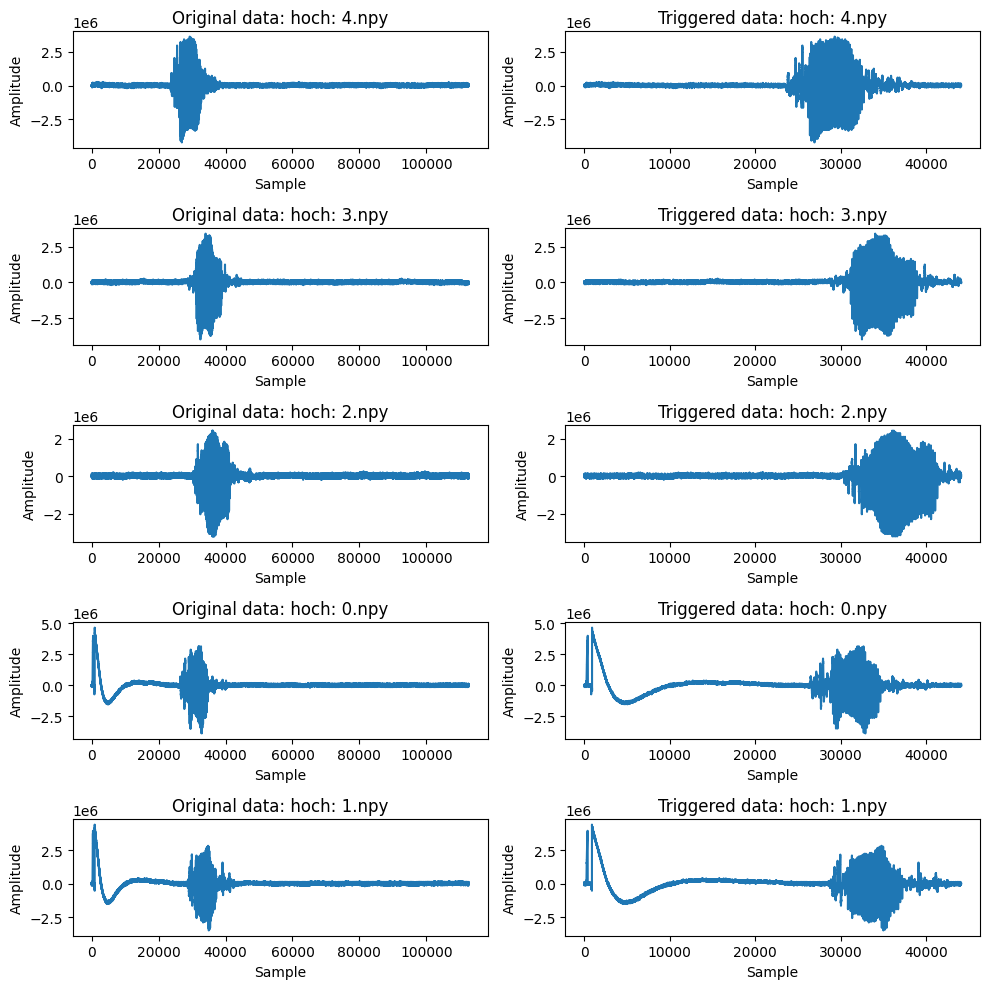

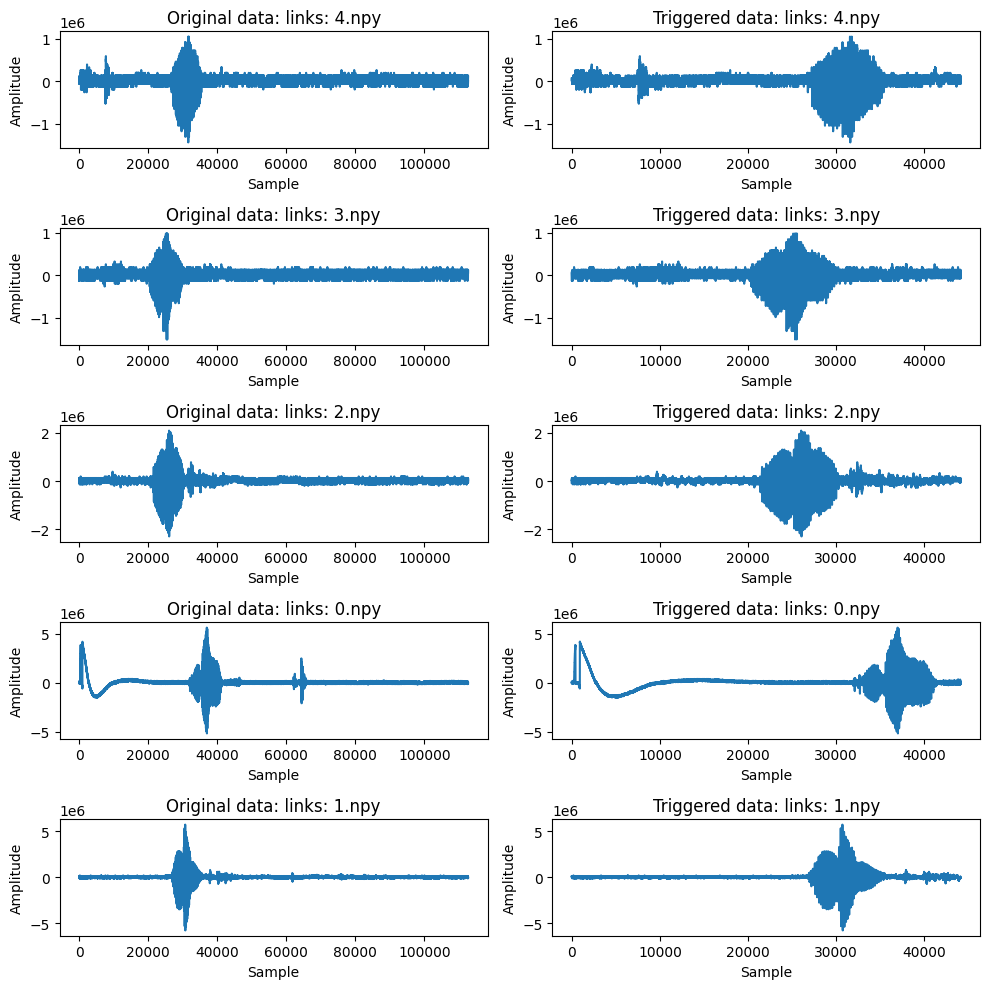

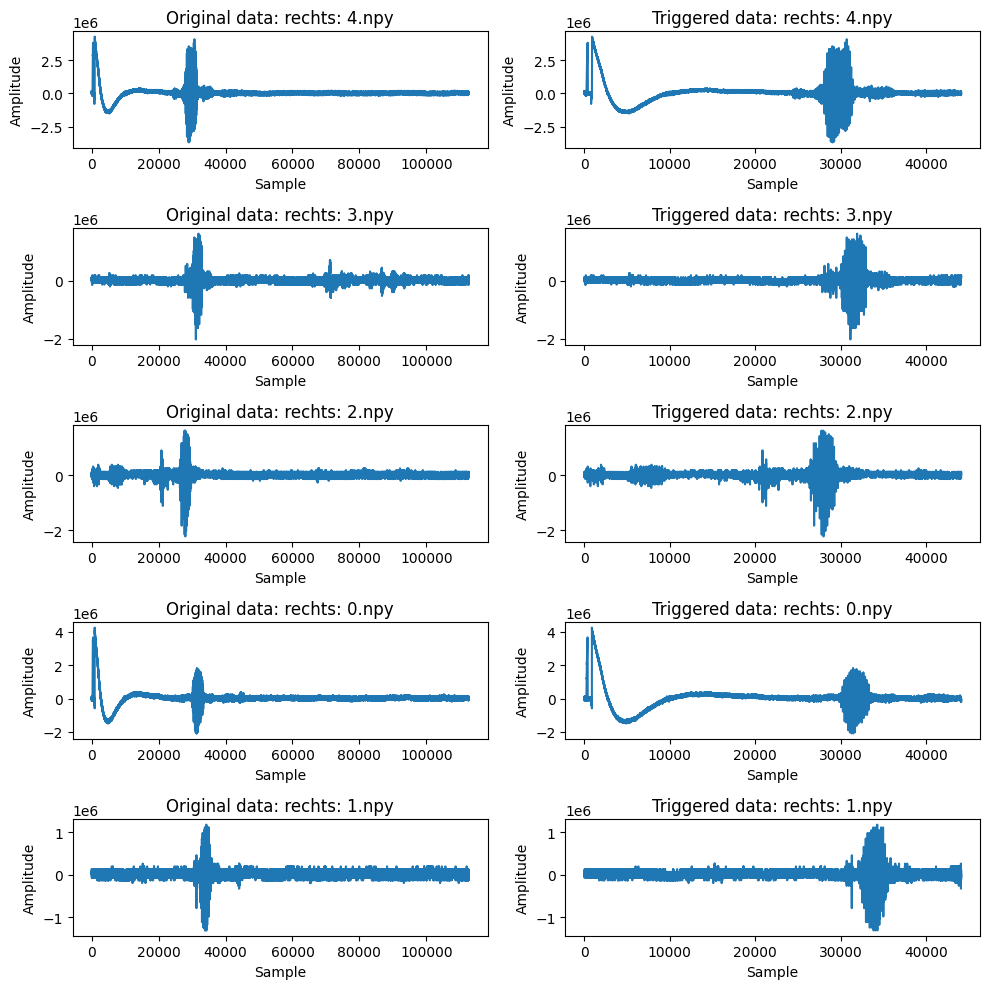

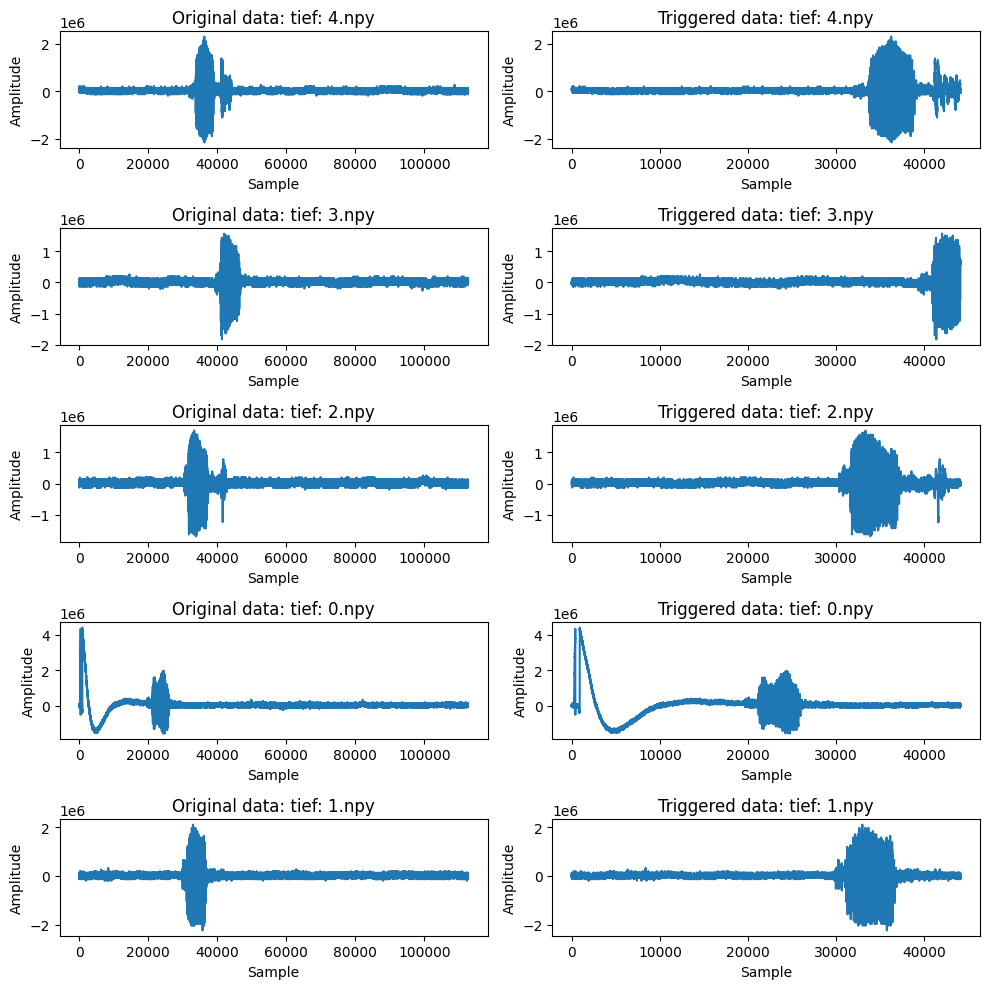

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.fft import fft, fftfreq

folders = ["hoch", "links", "rechts", "tief"]

#44.100 Abtastvorgänge pro Sekunde
def cut_signal(data, threshold=0.01, fs=44100):
    start_index = 0
    for i, sample in enumerate(data):
        if abs(sample) > threshold:
            start_index = i
            break
    end_index = start_index + fs
    cut_data = data[start_index:end_index]
    if len(cut_data) < fs:
        cut_data = np.append(cut_data, [0]*(fs - len(cut_data)))
    return cut_data

for folder in folders:
    files = [file for file in os.listdir(f"lars/{folder}") if file.endswith(".npy")]
    n = len(files)
    fig, axs = plt.subplots(n, 2, figsize=(10, n*2))
    fs = 44100

    for i, file in enumerate(files):
        data = np.load(f"lars/{folder}/" + file)
        triggered_data = cut_signal(data)

        # Plot original data
        axs[i, 0].plot(data)
        axs[i, 0].set_title(f"Original data: {folder}: {file}")
        axs[i, 0].set_xlabel('Sample')
        axs[i, 0].set_ylabel('Amplitude')

        # Plot triggered data
        axs[i, 1].plot(triggered_data)
        axs[i, 1].set_title(f"Triggered data: {folder}: {file}")
        axs[i, 1].set_xlabel('Sample')
        axs[i, 1].set_ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

c) Bestimmung des Amplitudenspektrums
Stelle dieses Amplitudenspektrum graphisch dar.

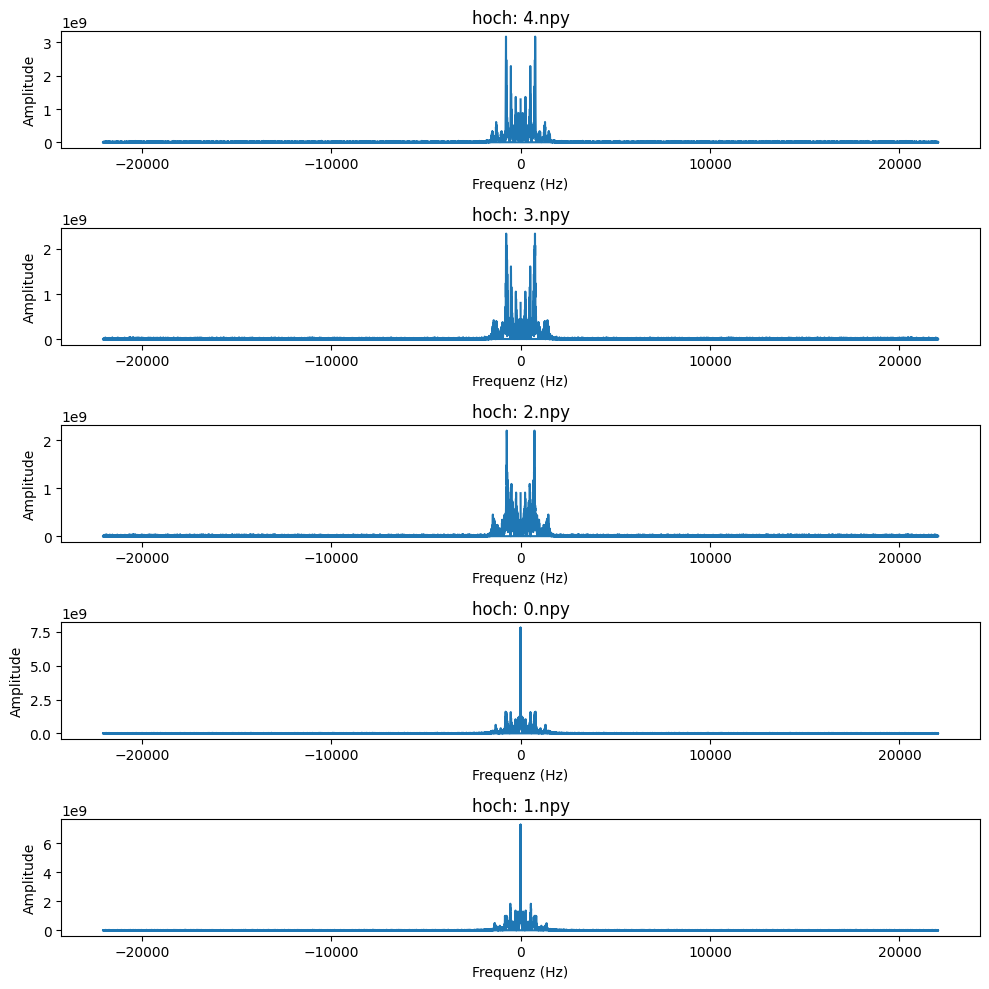

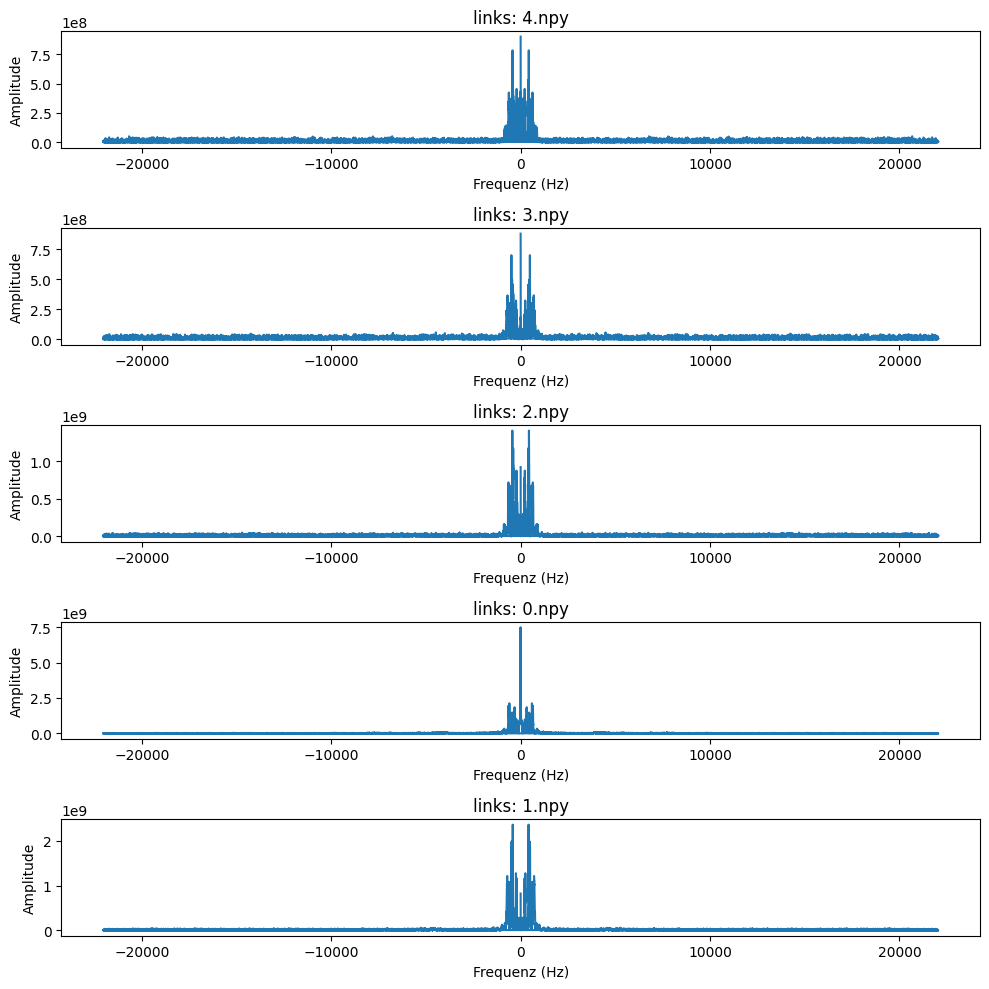

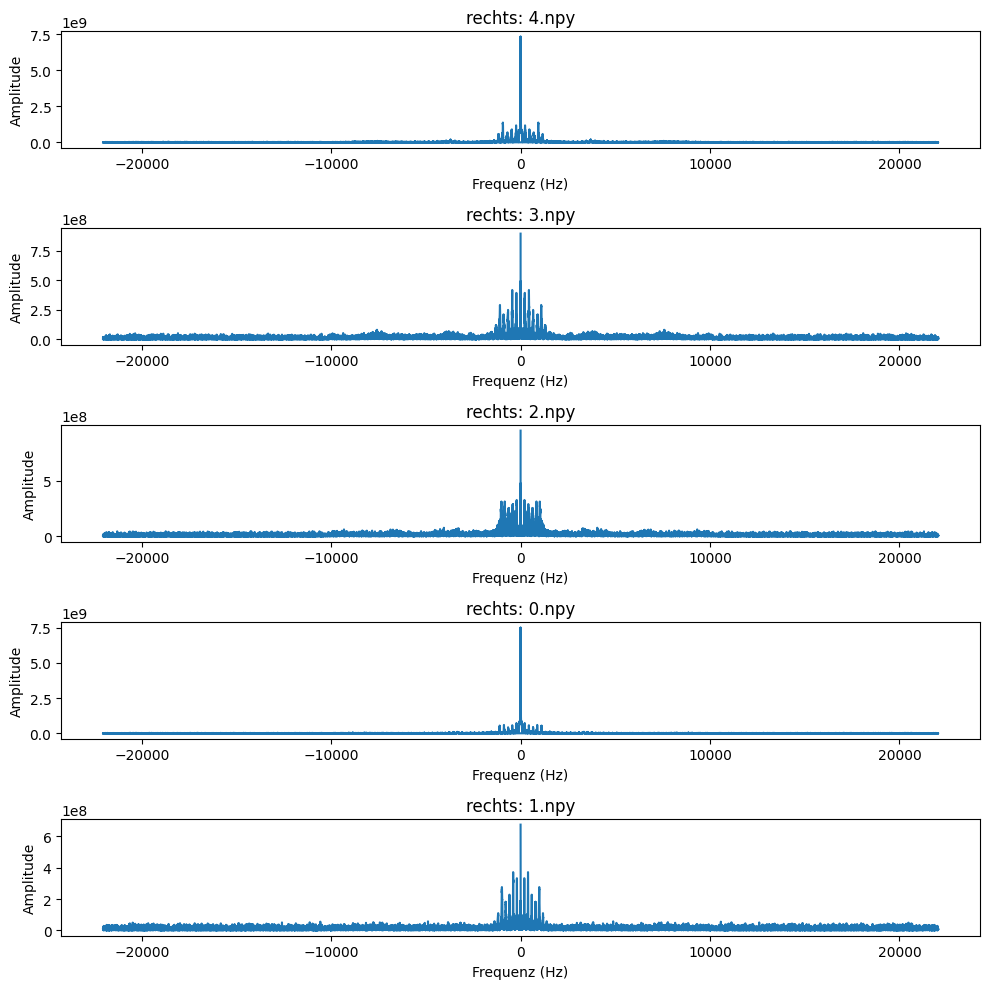

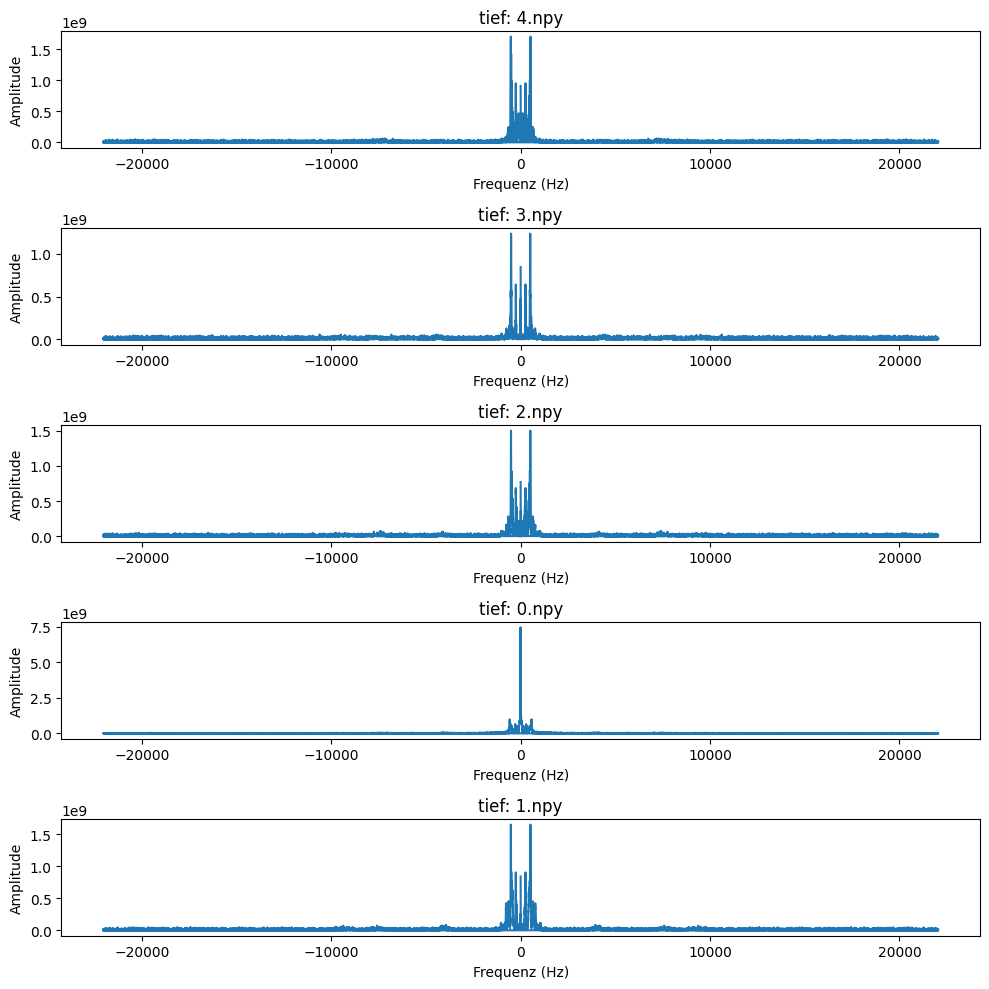

In [3]:
# Apply the function to the data
for folder in folders:
    files = [file for file in os.listdir(f"lars/{folder}") if file.endswith(".npy")]

    # Create a grid of 1 column and enough rows to hold all plots
    n = len(files)
    fig, axs = plt.subplots(n, 1, figsize=(10, n*2))
    fs = 44100

    for i, file in enumerate(files):
        data = np.load(f"lars/{folder}/" + file)
        triggered_data = cut_signal(data)

        # Compute the amplitude spectrum
        N = len(triggered_data)
        yf = fft(triggered_data)
        xf = fftfreq(N, 1 / 44100)

        axs[i].plot(xf, np.abs(yf))
        axs[i].set_title(f"{folder}: {file}")
        axs[i].set_xlabel('Frequenz (Hz)')  # Set x-axis label
        axs[i].set_ylabel('Amplitude')  # Set y-axis label

    plt.tight_layout()
    plt.show()

d) Implementierung des Windowing-Verfahrens

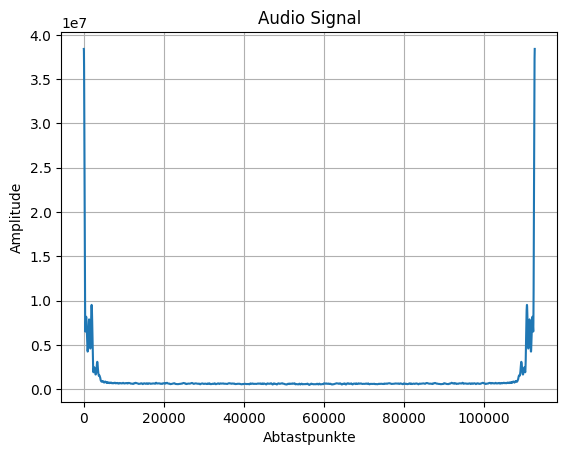

In [4]:
import scipy as sp

def slice_window(passed_array):
    gauss_window = np.array(sp.signal.windows.gaussian(512, 512 / 4))
    for i in range(0, len(passed_array) - 512 + 1, 256):
        yield np.concatenate([[0] * i, list(gauss_window * passed_array[i:i + 512]), [0] * (len(passed_array) - (i + 512))])


def windowing_func(passed_array):
    window = np.array(list(slice_window(passed_array)))
    return np.abs(np.fft.fft(window)).mean(0)


audio_sample = np.load('./lars/hoch/0.npy')
windowed_sample = windowing_func(audio_sample)

plt.plot(windowed_sample)
plt.xlabel('Abtastpunkte')
plt.ylabel('Amplitude')
plt.title('Audio Signal')
plt.grid(True)
plt.show()


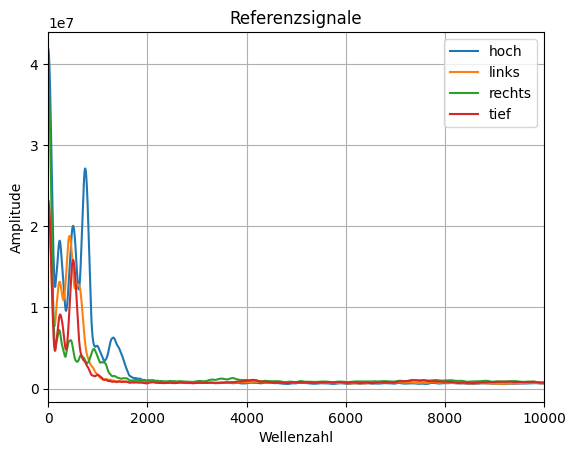

In [5]:
folders = ["hoch", "links", "rechts", "tief"]

spektren = dict()

for folder in folders:
    spektren[folder] = []

    for file in [file for file in os.listdir(f"lars/{folder}") if file.endswith(".npy")]:
        data = np.load(f"lars/{folder}/" + file)
        triggered_data = cut_signal(data)

        spektren[folder].append(windowing_func(triggered_data))
        
for word, values in spektren.items():
    plt.plot(np.mean(values, axis=0), label = word)
    plt.legend(loc="upper right")
    
plt.grid(True)
plt.title('Referenzsignale')
plt.xlabel('Wellenzahl')
plt.ylabel('Amplitude')
plt.xlim(0,10000)
plt.show()

In [6]:


def covariance(x, y, mean_x, mean_y):
    covar = 0.0
    for i in range(len(x)):
        covar += (x[i] - mean_x) * (y[i] - mean_y)
    return covar

def variance(values, mean_value):
    return sum((x - mean_value) ** 2 for x in values)

def correlation_coefficient(x, y):
    # Berechnung der Mittelwerte
    mean_x, mean_y = np.mean(x), np.mean(y)

    # Berechnung der Kovarianz und Varianz
    covar = covariance(x, y, mean_x, mean_y)
    var_x, var_y = variance(x, mean_x), variance(y, mean_y)

    # Berechnung des Korrelationskoeffizienten
    correlation = covar / (var_x * var_y) ** 0.5 if var_x != 0 and var_y != 0 else 0

    return correlation

# Beispiel:
referenzspektrum_1 = [1, 2, 3, 4, 5]
referenzspektrum_2 = [1, 2, 2, 3, 4]

korrelationskoeffizient = correlation_coefficient(referenzspektrum_1, referenzspektrum_2)
print(f"Korrelationskoeffizient: {korrelationskoeffizient}")


Korrelationskoeffizient: 0.9707253433941511


In [18]:
folders = ["hoch", "links", "rechts", "tief"]

def get_data(speaker, doThis = lambda x: x):
    spektren = dict()
    for folder in folders:
        spektren[folder] = []

        for file in [file for file in os.listdir(f"{speaker}/{folder}") if file.endswith(".npy")]:
            data = np.load(f"{speaker}/{folder}/" + file)
            triggered_data = cut_signal(data)

            spektren[folder].append(doThis(triggered_data))
    return spektren

def percentage(x):
    return f"{round(abs(x*100))}%"

def print_coef(data, data1, output):
    for word in folders:
        coef = []
        elements = min(len(data), len(data1))
        for index in range(elements):
            coef.append(correlation_coefficient(data[word][index], data1[word][index]))
            if(len(coef) == elements):
                print(f"{output} ({word}): {percentage(np.mean(coef))}")

def speech_recognition(spektren, reference):
    coef = dict()
    for word in reference.keys():
        coef[word] = []
        elements = min(len(reference[word]), len(spektren))
        for index in range(elements):
            coef[word].append(correlation_coefficient(spektren[index], reference[word][index]))
    toene_means = {key: sum(values) / len(values) for key, values in coef.items()}
    max_result = max(toene_means, key=toene_means.get)
    return (max_result, toene_means[max_result])

def test_speech_speech_recognition(data, reference, output):
    for word in folders:
        result = speech_recognition(data[word], reference)
        print(f"Try to recognize the word ({word}) {output}: {result[0]}: {percentage(result[1])}")
        
data = get_data("lars")
reference = get_data("lars") ## change to lars2
test_speech_speech_recognition(data, reference, "without windowing")

reference = get_data("andy")
test_speech_speech_recognition(data, reference, "of participant without windowing")

data = get_data("lars", windowing_func)
reference = get_data("lars", windowing_func) ## change to lars2
test_speech_speech_recognition(data, reference, "with windowing")

reference = get_data("andy", windowing_func)
test_speech_speech_recognition(data, reference, "of participant with windowing")


##
#nothing = lambda x: x
#print_coef(get_data("lars", nothing), get_data("lars", nothing),
#           "Recognition without windowing")   

#print_coef(get_data("lars", windowing_func), get_data("lars", windowing_func),
#           "Recognition with windowing")

#print_coef(get_data("lars", nothing), get_data("andy", nothing),
#           "Recognition of participant without windowing")      
#print("-")

#print_coef(get_data("lars", windowing_func), get_data("andy", windowing_func),
#           "Recognition of participant with windowing")


Try to recognize the word (hoch) without windowing: hoch: 100%
Try to recognize the word (links) without windowing: links: 100%
Try to recognize the word (rechts) without windowing: rechts: 100%
Try to recognize the word (tief) without windowing: tief: 100%
Try to recognize the word (hoch) of participant without windowing: rechts: 16%
Try to recognize the word (links) of participant without windowing: links: 13%
Try to recognize the word (rechts) of participant without windowing: links: 19%
Try to recognize the word (tief) of participant without windowing: links: 19%
Try to recognize the word (hoch) with windowing: hoch: 100%
Try to recognize the word (links) with windowing: links: 100%
Try to recognize the word (rechts) with windowing: rechts: 100%
Try to recognize the word (tief) with windowing: tief: 100%
Try to recognize the word (hoch) of participant with windowing: hoch: 78%
Try to recognize the word (links) of participant with windowing: links: 87%
Try to recognize the word (rec